In [1]:
## This is a series of examples using the icanswim/cosmosis data science and machine learning repo

In [2]:
from model import FFNet, tv_model
from learning import Learn, Selector, Metrics
from dataset import CDataset, SKDS, TVDS
from dataset import ImageDatasetStats, AsTensor, Squeeze, DType

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

In [3]:
## Example of generic/custom dataset and transforms
import numpy as np

class DummyDataset(CDataset):

    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([.02]),
                       'feature_3': np.asarray(['z1']),
                       'feature_4': np.asarray(['c','c','d']),
                       'feature_5': np.asarray([1.1])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([.01]),
                       'feature_3': np.asarray(['x1','z1','y1']),
                       'feature_4': np.asarray(['d','a','d']),
                       'feature_5': np.asarray([1.2])}}
        
        self.embed_lookup = {'feature_4': {'a': 1,'b': 2,'c': 3,'d': 4, '0': 0},
                             'feature_3': {'z1': 1, 'y1': 2, 'x1': 3, '0': 0}}
        
        print(boom)
        return datadic
    
class DummyTransform():
    def __call__(self, arr):
        return np.add(arr, 2)
    
class DummyTransformTwo():
    def __call__(self, arr):
        return np.multiply(arr, .1)
    
ds_params = {'train_params': {'input_dict': {'model_input': {'X1': ['feature_1','feature_5'],
                                                              'X2': ['feature_5'],
                                                              'embed': ['feature_3']},
                                             'criterion_input': {'y': ['feature_2'],
                                                                  'embed': ['feature_4']}},
                              'transform': [DummyTransform(), DummyTransformTwo()],
                              'target_transform': [],
                              'pad': 5,
                              'pad_feats': ['feature_5','feature_4'],
                              'boom': 'bang'}}
    
d = DummyDataset(**ds_params['train_params'])
d[2]

bang
CDataset created...


{'model_input': {'X1': tensor([0.2030, 0.3200, 0.2000, 0.2000, 0.2000, 0.2000], dtype=torch.float64),
  'X2': tensor([0.3200, 0.2000, 0.2000, 0.2000, 0.2000], dtype=torch.float64),
  'embed_idx': [array([3, 1, 2])]},
 'criterion_input': {'y': tensor([0.0100], dtype=torch.float64),
  'embed_idx': [array([4, 1, 4, 0, 0])]}}

In [4]:
## Example of sklearn regression dataset wrapper
ds_params = {'train_params': {'input_dict': {'model_input': {'features': ['X']},
                                             'criterion_input': {'targets': ['y']}},
                              'dataset': 'make_regression',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 5},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32'}}

sk = SKDS(**ds_params['train_params'])

sk[1]

creating scikit learn make_regression dataset...
CDataset created...


{'model_input': {'features': tensor([-1.3331,  0.7933,  0.0326,  1.6209,  0.1789])},
 'criterion_input': {'targets': tensor([78.7176])}}

In [5]:
## Example of sklearn classification dataset wrapper
ds_params = {'train_params': {'input_dict': {'model_input': {'features': ['X']},
                                             'criterion_input': {'targets': ['y']}},
                              'dataset': 'make_classification',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 10,
                                            'n_informative': 8,
                                            'n_clusters_per_class': 2,
                                            'flip_y': 0.05,
                                            'class_sep': 0.01,
                                            'n_classes': 4}}}

sk = SKDS(**ds_params['train_params'])

sk[1]

creating scikit learn make_classification dataset...
CDataset created...


{'model_input': {'features': tensor([ 0.3968,  1.2777, -2.3864,  0.3337,  0.2114, -0.2070, -1.4027,  0.7712,
          -1.0896,  0.8266])},
 'criterion_input': {'targets': tensor([1])}}

In [6]:
## Example of torchvision wrapper
ds_params={'dataset': 'MNIST',
           'input_dict': {'model_input': {'features': ['images'],},
                          'criterion_input': {'targets': ['labels']}},
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
tvds[1]

creating torch vision MNIST dataset...
CDataset created...


{'model_input': {'image': <PIL.Image.Image image mode=L size=224x224 at 0x7EFE11194EB0>},
 'criterion_input': {'target': 0}}

In [7]:
## Example of torchvision dataset wrapper with PIL transform
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

creating torch vision MNIST dataset...
CDataset created...
images to process: 60000
images processed: 10000
images processed: 20000
images processed: 30000
images processed: 40000
images processed: 50000
images processed: 60000
mean: [33.33091590401786], stddev: [73.70246726596685]
mean:  [33.33091590401786]
stddev:  [73.70246726596685]


creating scikit learn make_regression dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:02.868210
epoch: 0, lr: 0.01
train loss: 612554.7650462963, val loss: 522926.7215909091
test loss: 11424.208274147728
learning time: 0:00:10.490966


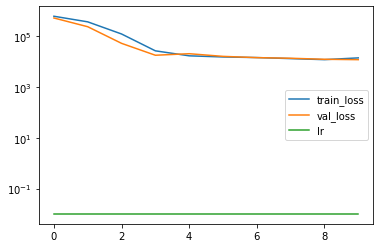

In [8]:
## Example sklearn regression dataset wrapper with custom model
model_params = {'D_in': 256, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'dataset': 'make_regression',
                              'as_tensor': True,
                              'transform': [],
                              'sk_params': {'n_samples':20000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10,
                  'log_plot': True}                         
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=10, gpu=True)

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:04.821874
epoch: 0, lr: 0.01
train loss: 1.3564178046289381, val loss: 1.2731007470024958
sklearn train metric: 0.5789525532126292, sklearn validation metric: 0.6689970503234741
learning time: 0:00:19.473069
epoch: 3, lr: 0.01
train loss: 0.9239071548640073, val loss: 0.8982384617512043
sklearn train metric: 0.8336835200862285, sklearn validation metric: 0.8410012557676079
learning time: 0:00:33.839302
epoch: 6, lr: 0.01
train loss: 0.7339366320725326, val loss: 0.777479939481132
sklearn train metric: 0.8805029921498413, sklearn validation metric: 0.8744409282278727
learning time: 0:00:48.139760
epoch: 9, lr: 0.01
train loss: 0.5849288811722955, val loss: 0.6008808574615381
sklearn train metric: 0.9356150718077013, sklearn validation metric: 0.933659928715289
test loss: 0.6210694886170901
learning time: 0:00:48.758354
sklearn test m

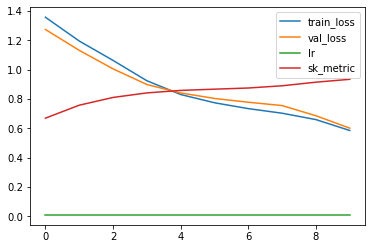

In [9]:
## Example sklearn classification dataset and metrics wrapper with custom model
model_params = {'D_in': 256, 
                'H': 128, 
                'D_out': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 100000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=(300,256,.2), batch_size=128, epochs=10, squeeze_y=True, save_model=True)

In [10]:
## Example inference with a sklearn classification dataset and metrics wrapper with custom model
model_params = {'D_in': 256, 
                'H': 128, 
                'D_out': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=None,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=128, epochs=1, squeeze_y=True, load_model='20221025_1522.pth')

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
model loaded from pickle...
running model on gpu...
inference 2022-10-25 15:27:41.957852 complete and saved to csv...


creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
torchvision model resnet18 loaded...
running model on gpu...
learning time: 0:00:05.028141
epoch: 0, lr: 0.01
train loss: 2.3298375606536865, val loss: 1.9960261487191724
sklearn train metric: 0.6448287072462257, sklearn validation metric: 0.7426583309044913
learning time: 0:00:19.497199
epoch: 3, lr: 0.01
train loss: 1.73839271068573, val loss: 1.754824121152201
sklearn train metric: 0.8125475976680919, sklearn validation metric: 0.8172804307269719
test loss: 1.737569034385681
learning time: 0:00:23.251072
sklearn test metric: 
0.8204546555555556 



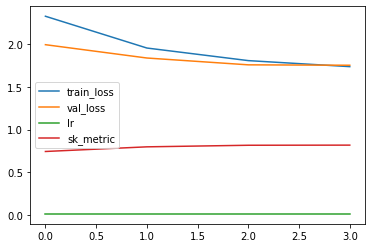

In [11]:
## Example torchvision dataset, transforms and model wrapper
model_params = {'model_name': 'resnet18',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(64),
                                                           transforms.ToTensor()]),
                                          'target_transform': None,
                                          'download': True}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(64),
                                                         transforms.ToTensor()]),
                                         'target_transform': None,
                                         'download': True}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params, 
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=16, epochs=4)

creating torch vision CIFAR10 dataset...
CDataset created...
creating torch vision CIFAR10 dataset...
CDataset created...
torchvision model resnext50_32x4d loaded...
running model on gpu...
learning time: 0:01:03.683153
epoch: 0, lr: 0.01
train loss: 2.6874300804138183, val loss: 2.127326594245049
sklearn train metric: 0.5771869888373676, sklearn validation metric: 0.6702105673040512
learning time: 0:02:06.995113
epoch: 1, lr: 0.01
train loss: 2.096894506454468, val loss: 2.014242018422773
sklearn train metric: 0.6855785416877563, sklearn validation metric: 0.735560955378679
learning time: 0:03:10.523799
epoch: 2, lr: 0.01
train loss: 2.0108309674263, val loss: 2.042109351004324
sklearn train metric: 0.7240656051209537, sklearn validation metric: 0.7330560710333724
learning time: 0:04:14.066982
epoch: 3, lr: 0.01
train loss: 1.9538259816169739, val loss: 1.9470855632135946
sklearn train metric: 0.7446032660557489, sklearn validation metric: 0.7646748659459504
test loss: 1.9500708898544

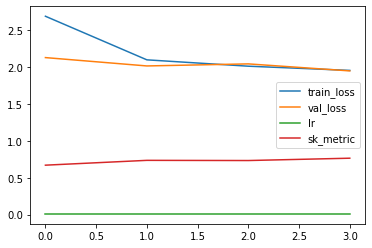

In [12]:
## Example torchvision dataset and model wrapper
model_params = {'model_name': 'resnext50_32x4d',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=16, epochs=4)